# InceptionV3

### Connect to Drive:

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1PxSEPrUvbOdLw4oR6K3poPNcUFwahzGX/Homework 1


### Import libraries:

In [ ]:
# Fix randomness and hide warnings:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
pip install imagehash

In [ ]:
# Import other libraries:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import PIL
from PIL import Image
import imagehash

In [ ]:
# Import useful items:
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

### Data import:

In [ ]:
data = np.load('public_data.npz', allow_pickle=True)
X0 = data['data']
y0 = data['labels']
y_aux_0 = y0

### Data preprocessing:

In [ ]:
# Normalization:
X0 =(X0/255).astype(np.float32)

# One-Hot encoding:
classnames, y0 = np.unique(y0, return_inverse=True)
y0= tfk.utils.to_categorical(y0,2)

In [ ]:
# Outliers removal:

# Shrek:
#plt.imshow(np.clip(X0[58], 0, 255))

# Trol:
#plt.imshow(np.clip(X0[2150], 0, 255))

ref_img_index1 = 58 # Shrek index
ref_img_index2 = 2150 # Trol index

img_1 = (X0[ref_img_index1] * 255).astype(np.uint8)
img_2 = (X0[ref_img_index2] * 255).astype(np.uint8)

hash_1 = imagehash.average_hash(Image.fromarray(img_1))
hash_2 = imagehash.average_hash(Image.fromarray(img_2))

rm_indexes = [ref_img_index1]
rm2_indexes = [ref_img_index2]

for i in range(len(X0)):
    if i != ref_img_index1 and imagehash.average_hash(Image.fromarray((X0[i] * 255).astype(np.uint8))) == hash_1:
        rm_indexes.append(i)
    elif i != ref_img_index2 and imagehash.average_hash(Image.fromarray((X0[i] * 255).astype(np.uint8))) == hash_2:
        rm2_indexes.append(i)

rm_indexes = list(set(rm_indexes))
rm2_indexes = list(set(rm2_indexes))

indexes_to_remove = rm_indexes + rm2_indexes

X = np.delete(X0, indexes_to_remove, axis=0)
y = np.delete(y0, indexes_to_remove, axis=0)
y_aux = np.delete(y_aux_0, indexes_to_remove, axis=0)

In [ ]:
# Inspect the dataset:
print('Dataset shape:')
print(X.shape)
print('Labels vector shape:')
print(y.shape)
labels = np.argmax(y, axis=1)
print('Counting occurrences of target classes:')
print(pd.DataFrame(labels, columns=['digit'])['digit'].value_counts())

Dataset shape:
(5004, 96, 96, 3)
Labels vector shape:
(5004, 2)
Counting occurrences of target classes:
0    3101
1    1903
Name: digit, dtype: int64


In [ ]:
# Data split:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4503, 96, 96, 3), y_train shape: (4503, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)


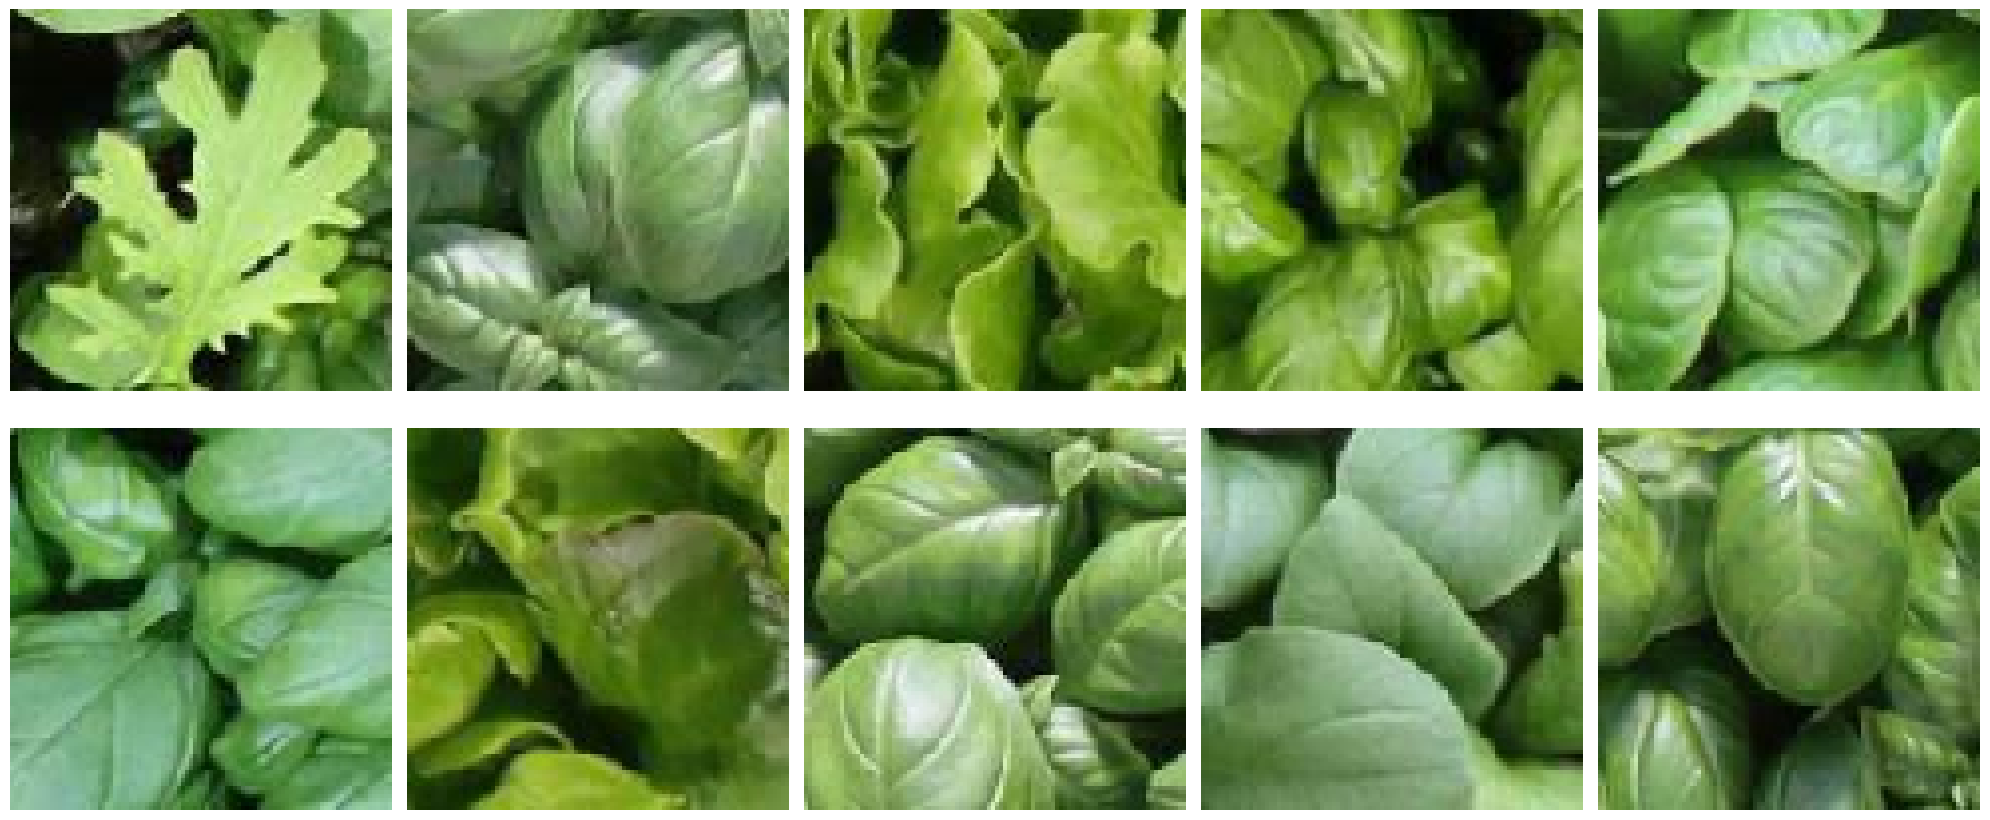

In [ ]:
# Data Visulization:
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X0[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

### Set parameters:

In [ ]:
batch_size = 64

epochs = 150
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=15, min_lr=1e-5, mode='max')
    ]

# for the tranfer learning part we use different callbacks:
epochs_tl = 20
callbacks_tl=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=10, min_lr=1e-5, mode='max')
    ]

### Data augmentation:

In [ ]:
train_datagen =  ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest'
)

valid_datagen = ImageDataGenerator() # transformations are only applied to the training set

train_generator = train_datagen.flow(
  X_train,y_train,
  batch_size=batch_size,
)

validation_generator = valid_datagen.flow(
  X_val,y_val,
  batch_size=batch_size,
)

### Model construction:

In [ ]:
# InceptionV3 model:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
    )

# Display model architecture:
#tfk.utils.plot_model(inceptionV3, show_shapes=True)

# Add MLP part:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

### Transfer Learning:

In [ ]:
# FEN layers are not trainable:
for layer in base_model.layers:
  layer.trainable = False

#model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training:

tl_history = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs_tl,
    validation_data = validation_generator,
    callbacks = callbacks_tl
).history

Epoch 1/20
71/71 [==============================] - 22s 235ms/step - loss: 1.0336 - accuracy: 0.6325 - val_loss: 0.5951 - val_accuracy: 0.6926 - lr: 0.0010
Epoch 2/20
71/71 [==============================] - 15s 208ms/step - loss: 0.5902 - accuracy: 0.6889 - val_loss: 0.5474 - val_accuracy: 0.7246 - lr: 0.0010
Epoch 3/20
71/71 [==============================] - 14s 201ms/step - loss: 0.5673 - accuracy: 0.7078 - val_loss: 0.5514 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 4/20
71/71 [==============================] - 15s 207ms/step - loss: 0.5739 - accuracy: 0.7064 - val_loss: 0.5401 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 5/20
71/71 [==============================] - 17s 241ms/step - loss: 0.5494 - accuracy: 0.7155 - val_loss: 0.5333 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 6/20
71/71 [==============================] - 18s 252ms/step - loss: 0.5431 - accuracy: 0.7200 - val_loss: 0.5415 - val_accuracy: 0.7265 - lr: 0.0010
Epoch 7/20
71/71 [==============================] - 15s 208ms/st

In [ ]:
model.save('InceptionTransferLearningAugmentation2')

### Fine Tuning:

In [ ]:
model = tfk.models.load_model('InceptionTransferLearningAugmentation2')

In [ ]:
# Set the trainable layers, from the N-th onwards
N = 196
for layer in model.layers[:N]: # mixed3: 100, mixed4: 132, mixed5: 164, mixed6: 196, mixed7: 228
    layer.trainable = False
for layer in model.layers[N:]:
    layer.trainable = True

#for i, layer in enumerate(model.layers):
#   print(i, layer.name, layer.trainable)

#model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training:

ft_history = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks
).history

Epoch 1/150
71/71 [==============================] - 37s 266ms/step - loss: 0.5648 - accuracy: 0.7169 - val_loss: 2.1263 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 2/150
71/71 [==============================] - 15s 210ms/step - loss: 0.4942 - accuracy: 0.7742 - val_loss: 4.0524 - val_accuracy: 0.7665 - lr: 0.0010
Epoch 3/150
71/71 [==============================] - 17s 246ms/step - loss: 0.4715 - accuracy: 0.7908 - val_loss: 2.0064 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 4/150
71/71 [==============================] - 16s 224ms/step - loss: 0.4439 - accuracy: 0.8066 - val_loss: 1.8224 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 5/150
71/71 [==============================] - 15s 219ms/step - loss: 0.4386 - accuracy: 0.8148 - val_loss: 0.4295 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 6/150
71/71 [==============================] - 16s 219ms/step - loss: 0.3947 - accuracy: 0.8281 - val_loss: 0.4234 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 7/150
71/71 [==============================] - 16s 2

In [ ]:
#model.save('InceptionFineTuningAugmentation_196')

### Results visualization:

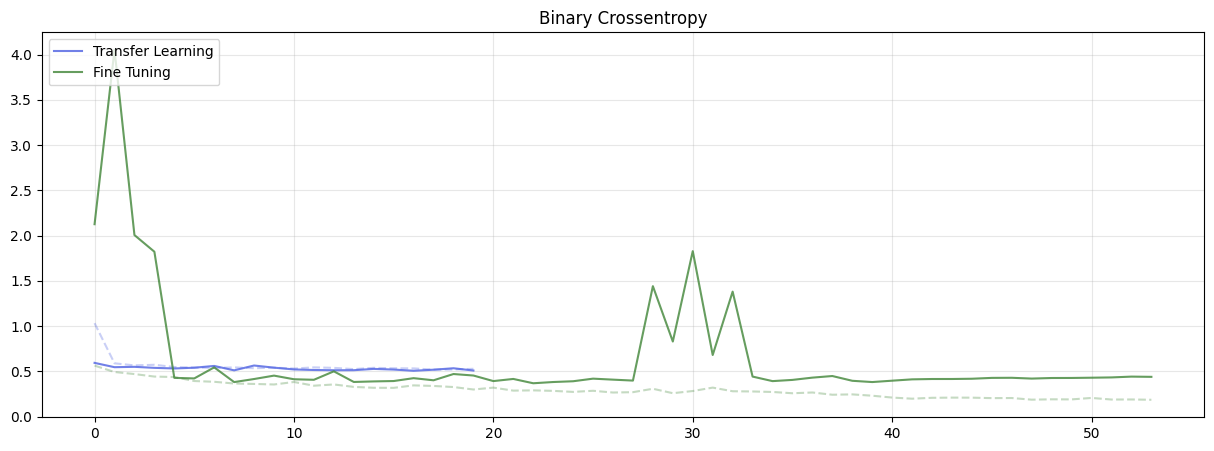

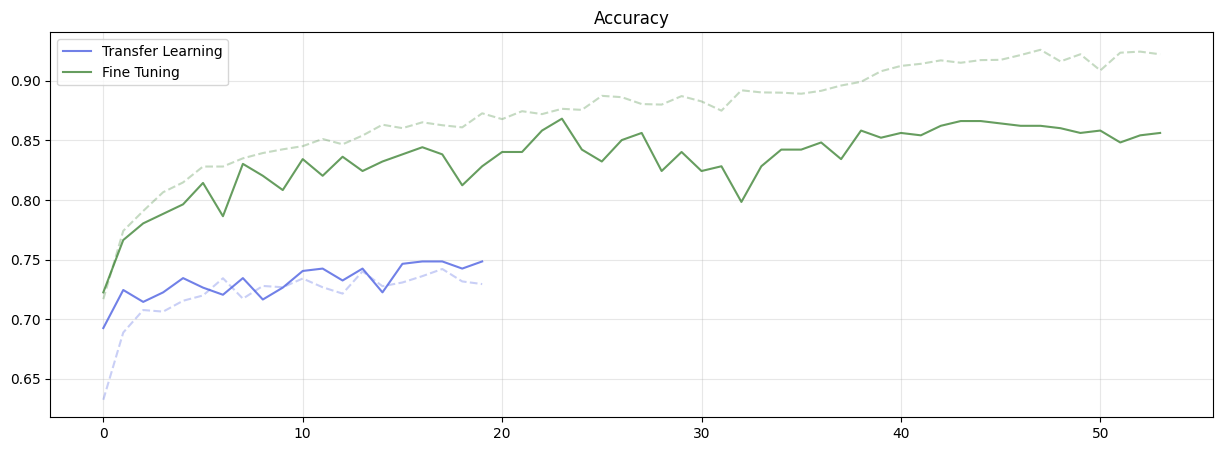

In [ ]:
# Plot the transfer learning and the fine-tuned InceptionV3 training histories:

plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Make inference:

In [ ]:
current_dir = os.getcwd()
model = tfk.models.load_model(os.path.join(current_dir, 'promising_models', 'InceptionFineTuningAugmentation_196'))
#model = ('InceptionTransferLearningAugmentation2')

Accuracy: 0.8643
Precision: 0.8554
Recall: 0.8582
F1: 0.8567


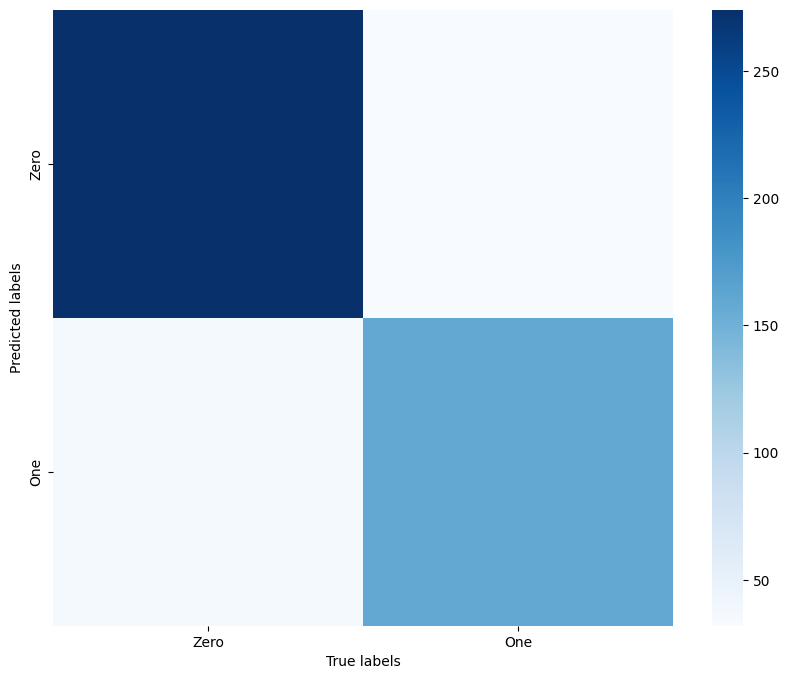

In [ ]:
# Predict labels for the entire validation set:
predictions = model.predict(X_val, verbose=0)

# Compute the confusion matrix:
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics:
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics:
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix:
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Add balancing weights:

In [ ]:
classnames, y_aux = np.unique(y_aux, return_inverse=True)
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_aux),
                                        y = y_aux
                                    )
class_weights = dict(zip(np.unique(y_aux), class_weights))
print(class_weights)

{0: 0.8068365043534343, 1: 1.3147661586967945}


#### Transfer Learning:

In [ ]:
# InceptionV3 model:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(96,96,3)
    )

# Display model architecture:
#tfk.utils.plot_model(inceptionV3, show_shapes=True)

# Add MLP part:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# FEN layers are not trainable:
for layer in base_model.layers:
  layer.trainable = False

#model.summary()

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training:

tl_history_balanced = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs_tl,
    validation_data = validation_generator,
    callbacks = callbacks_tl,
    class_weight=class_weights
).history

Epoch 1/20
71/71 [==============================] - 35s 362ms/step - loss: 0.8958 - accuracy: 0.6196 - val_loss: 0.5736 - val_accuracy: 0.7006 - lr: 0.0010
Epoch 2/20
71/71 [==============================] - 15s 215ms/step - loss: 0.6239 - accuracy: 0.6551 - val_loss: 0.5783 - val_accuracy: 0.7026 - lr: 0.0010
Epoch 3/20
71/71 [==============================] - 15s 218ms/step - loss: 0.5907 - accuracy: 0.6738 - val_loss: 0.5437 - val_accuracy: 0.7086 - lr: 0.0010
Epoch 4/20
71/71 [==============================] - 14s 197ms/step - loss: 0.5911 - accuracy: 0.6809 - val_loss: 0.5588 - val_accuracy: 0.7246 - lr: 0.0010
Epoch 5/20
71/71 [==============================] - 14s 198ms/step - loss: 0.5856 - accuracy: 0.6898 - val_loss: 0.5517 - val_accuracy: 0.7066 - lr: 0.0010
Epoch 6/20
71/71 [==============================] - 15s 209ms/step - loss: 0.5753 - accuracy: 0.6918 - val_loss: 0.5384 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 7/20
71/71 [==============================] - 16s 224ms/st

In [ ]:
#model.save('InceptionTransferLearningAugmentation_balanced')

#### Fine Tuning:

In [ ]:
#current_dir = os.getcwd()
#model = tfk.models.load_model(os.path.join(current_dir, 'development_models', 'InceptionTransferLearningAugmentation2'))

#model = tfk.models.load_model('InceptionTransferLearningAugmentation_balanced')

In [ ]:
# Set the trainable layers, from the N-th onwards
N = 196
for layer in model.layers[:N]: # mixed3: 100, mixed4: 132, mixed5: 164, mixed6: 196, mixed7: 228
    layer.trainable = False
for layer in model.layers[N:]:
    layer.trainable = True

#for i, layer in enumerate(model.layers):
#   print(i, layer.name, layer.trainable)

#model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ft_history_balanced = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks,
    class_weight=class_weights
).history

Epoch 1/150
71/71 [==============================] - 32s 236ms/step - loss: 0.6020 - accuracy: 0.7069 - val_loss: 0.6832 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 2/150
71/71 [==============================] - 16s 218ms/step - loss: 0.5372 - accuracy: 0.7491 - val_loss: 0.5662 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 3/150
71/71 [==============================] - 15s 211ms/step - loss: 0.4777 - accuracy: 0.7697 - val_loss: 0.4538 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 4/150
71/71 [==============================] - 14s 193ms/step - loss: 0.4505 - accuracy: 0.7917 - val_loss: 0.4212 - val_accuracy: 0.8104 - lr: 0.0010
Epoch 5/150
71/71 [==============================] - 16s 220ms/step - loss: 0.4517 - accuracy: 0.7972 - val_loss: 0.9653 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 6/150
71/71 [==============================] - 17s 233ms/step - loss: 0.4508 - accuracy: 0.8095 - val_loss: 1.2197 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 7/150
71/71 [==============================] - 15s 2

In [ ]:
model.save('InceptionFineTuningAugmentation_196_balanced')

#### Result visualization:

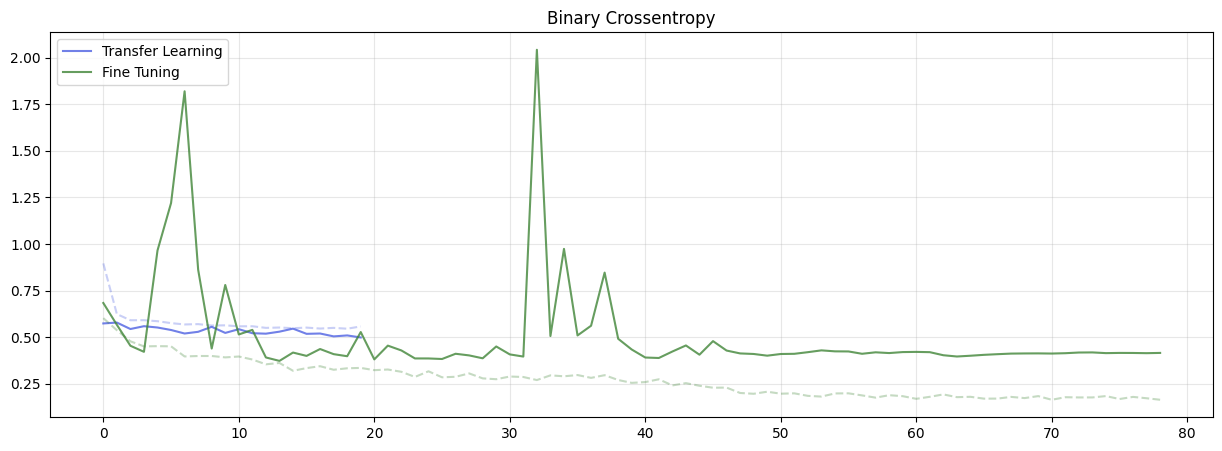

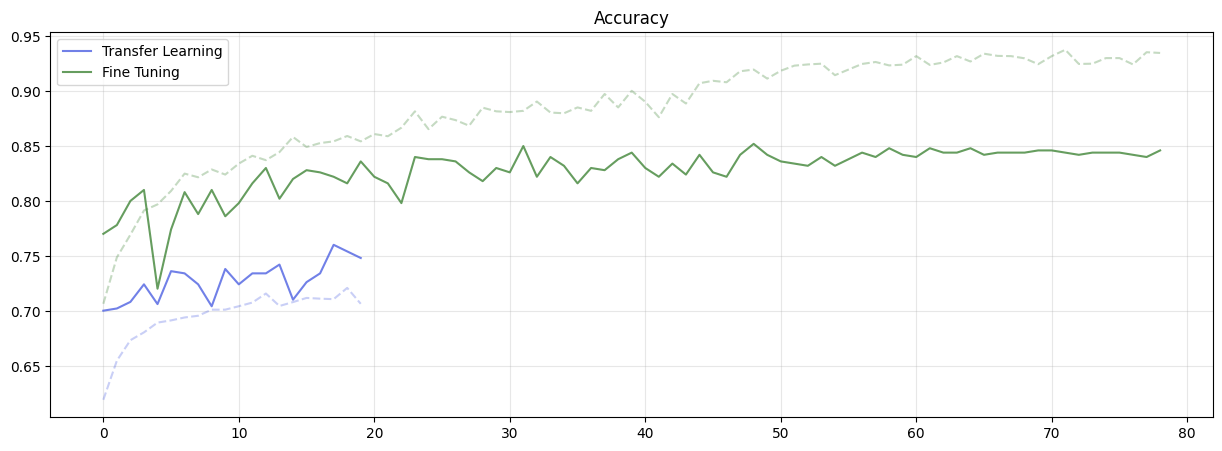

In [ ]:
# Plot the transfer learning and the fine-tuned InceptionV3 training histories:

plt.figure(figsize=(15,5))
plt.plot(tl_history_balanced['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history_balanced['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history_balanced['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history_balanced['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history_balanced['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history_balanced['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history_balanced['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history_balanced['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#### Make inference:

Accuracy: 0.8523
Precision: 0.8435
Recall: 0.8435
F1: 0.8435


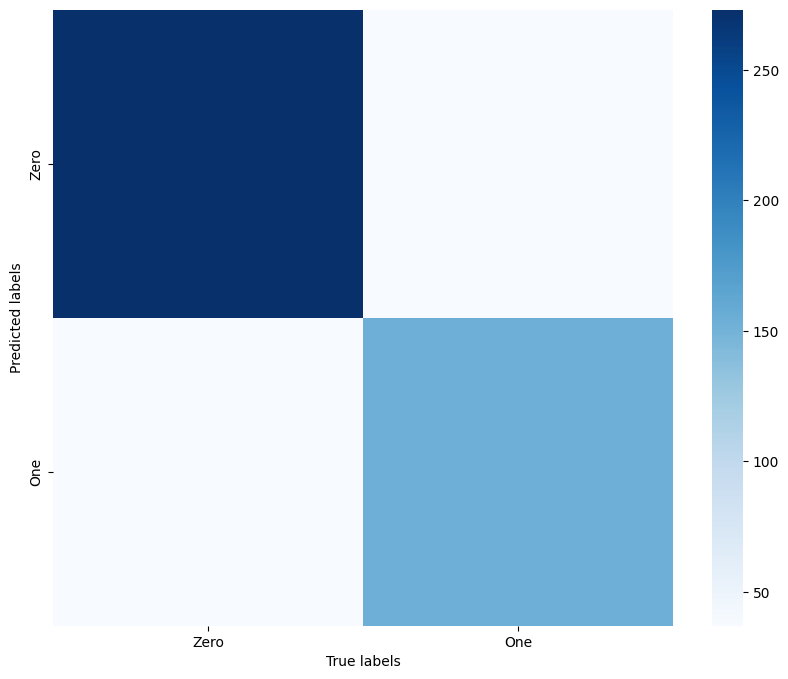

In [ ]:
# Predict labels for the entire validation set:
predictions = model.predict(X_val, verbose=0)

# Compute the confusion matrix:
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics:
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics:
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix:
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### High precision model:

In [ ]:
classnames, y_aux = np.unique(y_aux, return_inverse=True)
class_weights = compute_class_weight(
                                        class_weight = {0:0.70, 1:0.30},
                                        classes = np.unique(y_aux),
                                        y = y_aux
                                    )
class_weights = dict(zip(np.unique(y_aux), class_weights))
print(class_weights)

#### Transfer Learning:

In [ ]:
# FEN layers are not trainable:
for layer in base_model.layers:
  layer.trainable = False

#model.summary()

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training:

tl_history_balanced = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs_tl,
    validation_data = validation_generator,
    callbacks = callbacks_tl,
    class_weight=class_weights
).history

In [ ]:
#model.save('InceptionTransferLearningAugmentation_balanced')

#### Fine Tuning:

In [ ]:
current_dir = os.getcwd()
model = tfk.models.load_model(os.path.join(current_dir, 'development_models', 'InceptionTransferLearningAugmentation2'))

#model = tfk.models.load_model('InceptionTransferLearningAugmentation_balanced')

In [ ]:
# Set the trainable layers, from the N-th onwards
N = 196
for layer in model.layers[:N]: # mixed3: 100, mixed4: 132, mixed5: 164, mixed6: 196, mixed7: 228
    layer.trainable = False
for layer in model.layers[N:]:
    layer.trainable = True

#for i, layer in enumerate(model.layers):
#   print(i, layer.name, layer.trainable)

#model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ft_history_balanced = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks,
    class_weight=class_weights
).history

In [ ]:
model.save('InceptionFineTuningAugmentation_196_75')

#### Make inference:

In [ ]:
model = tfk.models.load_model('InceptionFineTuningAugmentation_196_70')

In [ ]:
# Predict labels for the entire validation set:
predictions = model.predict(X_val, verbose=0)

# Compute the confusion matrix:
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics:
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics:
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix:
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Ensemble model:

In [ ]:
# model1:
# Inception_alldata or InceptionFineTuningAugmentation_196:
current_dir = os.getcwd()
model1 = tfk.models.load_model(os.path.join(current_dir, 'development_models', 'InceptionFineTuningAugmentation_196'))

In [ ]:
# model2:
# InceptionFineTuningAugmentation_196_75
current_dir = os.getcwd()
model2 = tfk.models.load_model(os.path.join(current_dir, 'development_models', 'InceptionFineTuningAugmentation_196'))

In [ ]:
prediactions1 = model1.predict(X_val, verbose=0)
predictions2 = model2.predict(X_val, verbose=0)

print(predictions1)
print(predictions2)

# weights:
w1 = 0.5
w2 = 0.5

# weighted average:
predictions = (w1 * predictions1 + w2 * predictions2) / (w1 + w2)
print(predictions)

In [ ]:
# Compute the confusion matrix:
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics:
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics:
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix:
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### with KerasCV (only transfer learning):

In [ ]:
# we apply the transformations only to the training set
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train,y_train,
  batch_size=64,
)
validation_generator = valid_datagen.flow(
  X_val,y_val,
  batch_size=64,
)

In [ ]:
input_shape=(96,96,3)
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=input_shape)
batch_size = 128
epochs = 100
#learning_rate = 1e-4
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

model=Sequential()
model.add(keras_cv.layers.RandomColorDegeneration((0.5,0.5), seed=None, input_shape=input_shape))
model.add(keras_cv.layers.RandomHue((0.5,0.5),[0,1] ,seed=None, input_shape=input_shape))
model.add(keras_cv.layers.RandomSaturation((0.5,0.5) ,seed=None, input_shape=input_shape))
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [ ]:
#transfer learning:
for layer in base_model.layers:
  layer.trainable = False
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks
).history

Epoch 1/100
71/71 [==============================] - 87s 1s/step - loss: 0.9445 - accuracy: 0.6072 - val_loss: 0.6375 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 2/100
71/71 [==============================] - 73s 1s/step - loss: 0.7664 - accuracy: 0.6485 - val_loss: 0.5587 - val_accuracy: 0.7285 - lr: 0.0010
Epoch 3/100
71/71 [==============================] - 76s 1s/step - loss: 0.7164 - accuracy: 0.6551 - val_loss: 0.6299 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - 74s 1s/step - loss: 0.6673 - accuracy: 0.6731 - val_loss: 0.5867 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 5/100
71/71 [==============================] - 72s 1s/step - loss: 0.6560 - accuracy: 0.6660 - val_loss: 0.5399 - val_accuracy: 0.7246 - lr: 0.0010
Epoch 6/100
71/71 [==============================] - 75s 1s/step - loss: 0.6215 - accuracy: 0.6882 - val_loss: 0.5268 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 7/100
71/71 [==============================] - 71s 1s/step - loss: 0.6

In [ ]:
model.save('InceptionTransferLearning_KerasCV')